# Radial Chromosome Position Analysis

In [49]:
import random, os, sys
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
sys.path.append(os.path.abspath(os.path.join(r"..", r".")))

%matplotlib notebook

from source import const

In [5]:
pgp_file = "../datasets/Table_S1_pgp1_data_table.csv"
pgp_data = pd.read_csv(pgp_file,index_col=False)

In [84]:
def homolog_unaware_rdist_vector(cell,r):
    sizes = const.SIZES_HG38
    
    r = []
    for i in range(len(sizes)):
        r.append([])
    
    
    
    for i, row in cell.iterrows():
    
        if row["hg38_chr"] > len(sizes)-1: continue
        
        r[row["hg38_chr"]].append(row['norm_r_3D'])
    
    r2 = np.zeros(len(sizes)-1)
    for i in range(1,len(r)):
        r2[i-1] = np.nanmean(r[i])

    return r, r2


def homolog_unaware_rdist_vector(cell,r):
    
    sizes = const.SIZES_HG38
    
    for i, row in cell.iterrows():
    
        if row["hg38_chr"] > len(sizes)-1: continue
        
        r[row["hg38_chr"]].append(row['norm_r_2D'])
    
    r2 = np.zeros(len(sizes)-1)
    for i in range(1,len(r)):
        r2[i-1] = np.nanmean(r[i])

    return r, r2



def homolog_unaware_rdist_ensemble(cells):
    
    sizes = const.SIZES_HG38
    
    R = []
    for i in range(len(sizes)):
        R.append([])
    
    R_flat = []
    
    for cell in cells:
        
        R, r2 = homolog_unaware_rdist_vector(cell,R)
        
        R_flat.append(r2)
    
    R, R_flat = np.array(R), np.array(R_flat)
    
    return R, R_flat

# Without normalization

In [85]:
cells = []
cell_indices = pgp_data["cell_id"].unique()

for cell_index in cell_indices:
    cells.append(pgp_data.loc[pgp_data["cell_id"] == cell_index])

In [86]:
R, R_flat = homolog_unaware_rdist_ensemble(cells)

In [87]:
#citation: http://www.jtrive.com/the-empirical-bootstrap-for-confidence-intervals-in-python.html
def bootstrap(data, n=1000, func=np.mean):
    """
    Generate `n` bootstrap samples, evaluating `func`
    at each resampling. `bootstrap` returns a function,
    which can be called to obtain confidence intervals
    of interest.
    """
    simulations = list()
    sample_size = len(data)
    xbar_init = np.mean(data)
    for c in range(n):
        itersample = np.random.choice(data, size=sample_size, replace=True)
        simulations.append(func(itersample))
    simulations.sort()

    def ci(p):
        """
        Return 2-sided symmetric confidence interval specified
        by p.
        """
        u_pval = (1+p)/2.
        l_pval = (1-u_pval)
        l_indx = int(np.floor(n*l_pval))
        u_indx = int(np.floor(n*u_pval))
        
        return(simulations[l_indx],simulations[u_indx])
    return(ci)

In [88]:
mean_r = []
CIs = []
for i in range(0, len(R)):
    mean_r.append(np.nanmean(R[i]))
    boot = bootstrap(R[i])
    interval = boot(.95)
    err = np.array([mean_r[i] - interval[0], interval[1] - mean_r[i]])
    CIs.append(err)

/Users/acp/miniconda2/envs/gwis2/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


In [89]:
CIs =np.array(CIs)

<IPython.core.display.Javascript object>


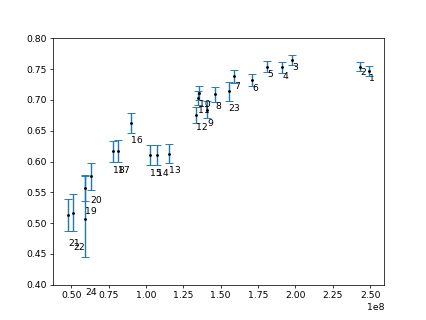

(0.4, 0.8)

In [92]:
sizes = const.SIZES_HG38
fig = plt.figure()
ax = fig.add_subplot(111)


eb1 = ax.errorbar(sizes[1:], mean_r[1:], ls='',yerr=CIs[1:].T, marker='o',capsize=4,markersize=2, 
                  markerfacecolor='k', markeredgecolor='k')
#ax.scatter(sizes[1:],mean_r[1:])

for i in range(len(sizes)):
    
    ax.text(sizes[i], mean_r[i]-2*CIs[i][0], str(i))

ax.set_ylim(0.4,0.8)